# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [4]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import abc
from sys import getsizeof
import cv2
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
% matplotlib inline

We set the random seed so that the results don't vary drastically.

In [5]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, Dropout, TimeDistributed, Flatten, BatchNormalization, Activation, CuDNNLSTM
from keras.layers.convolutional import Conv3D, Conv2D, MaxPooling3D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.applications.vgg16 import VGG16

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [9]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 32

train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())
batch_size = 32

In [10]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [11]:
class AbsModel(metaclass= abc.ABCMeta):
    
    def initialize_params(self,image_height=100,image_width=100,frames_to_sample=30,batch_size=20,num_epochs=20):
        project_folder = 'Project_data'
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.single_batch(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.single_batch(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def single_batch(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            #imgs.sort()
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))

            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_val_generate(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

        callbacks_list = [checkpoint, LR, earlyStopping]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size
                                 
                                 )
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

In [7]:
class ModelConv3Dsamp(AbsModel):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [44]:
conv_3dsamp=ModelConv3Dsamp()
conv_conv_3dsamp3d1.initialize_params(image_height=100,image_width=100,frames_to_sample=16,batch_size=60,num_epochs=2)
conv_3dsamp_model=conv_3d1.define_model()
print("Total Params:", conv_3dsamp_model.count_params())
conv_3dsamp.train_val_generate(conv_3dsamp_model)

Total Params: 687813
Epoch 1/2


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


12/12 [==============================] - 50s 4s/step - loss: 1.7165 - categorical_accuracy: 0.3912 - val_loss: 1.7517 - val_categorical_accuracy: 0.3000

Epoch 00001: saving model to model_init_2020-06-2616_58_39.138652/model-00001-1.78171-0.36953-1.75174-0.30000.h5
Epoch 2/2
12/12 [==============================] - 30s 3s/step - loss: 1.1022 - categorical_accuracy: 0.5478 - val_loss: 1.7332 - val_categorical_accuracy: 0.4400

Epoch 00002: saving model to model_init_2020-06-2616_58_39.138652/model-00002-1.13677-0.53846-1.73323-0.44000.h5


### Model CNN (Conv3D)

In [9]:
class ModelConv3D1(AbsModel):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [10]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_params(image_height=160,image_width=160,frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1_model.summary()

Total Params: 1117061
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_2 (Activation)    (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 80, 80, 32)   

In [11]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_val_generate(conv_3d1_model)

Total Params: 1117061
Epoch 1/15
17/17 [==============================] - 167s 10s/step - loss: 1.6257 - categorical_accuracy: 0.3795 - val_loss: 3.4260 - val_categorical_accuracy: 0.3200

Epoch 00001: saving model to model_init_2020-06-3005_09_52.890084/model-00001-1.62717-0.37707-3.42604-0.32000.h5
Epoch 2/15
17/17 [==============================] - 56s 3s/step - loss: 1.0556 - categorical_accuracy: 0.5878 - val_loss: 1.1297 - val_categorical_accuracy: 0.5400

Epoch 00002: saving model to model_init_2020-06-3005_09_52.890084/model-00002-1.05842-0.58522-1.12968-0.54000.h5
Epoch 3/15
17/17 [==============================] - 59s 3s/step - loss: 0.7874 - categorical_accuracy: 0.6989 - val_loss: 1.3302 - val_categorical_accuracy: 0.6100

Epoch 00003: saving model to model_init_2020-06-3005_09_52.890084/model-00003-0.79330-0.69683-1.33025-0.61000.h5
Epoch 4/15
17/17 [==============================] - 60s 4s/step - loss: 0.6227 - categorical_accuracy: 0.7931 - val_loss: 0.8525 - val_categor

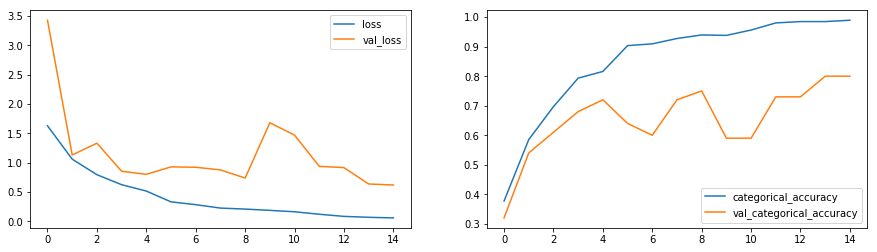

In [12]:
plot(history_model1)

In [13]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_params(image_height=160,image_width=160,frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
print("Total Params:", conv_3d2_model.count_params())
conv_3d2_model.summary()

Total Params: 3638981
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_5 (Activation)    (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_6 (Activation)    (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 10, 80, 80, 32)   

In [14]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_val_generate(conv_3d2_model,augment_data=True)


Total Params: 3638981
Epoch 1/25
34/34 [==============================] - 147s 4s/step - loss: 2.0059 - categorical_accuracy: 0.3793 - val_loss: 3.2292 - val_categorical_accuracy: 0.4800

Epoch 00001: saving model to model_init_2020-06-3005_26_39.471389/model-00001-1.96584-0.38462-3.22924-0.48000.h5
Epoch 2/25
34/34 [==============================] - 134s 4s/step - loss: 1.5746 - categorical_accuracy: 0.4904 - val_loss: 2.2728 - val_categorical_accuracy: 0.5700

Epoch 00002: saving model to model_init_2020-06-3005_26_39.471389/model-00002-1.53231-0.49020-2.27276-0.57000.h5
Epoch 3/25
34/34 [==============================] - 138s 4s/step - loss: 1.2570 - categorical_accuracy: 0.5710 - val_loss: 1.3248 - val_categorical_accuracy: 0.6600

Epoch 00003: saving model to model_init_2020-06-3005_26_39.471389/model-00003-1.17699-0.58522-1.32485-0.66000.h5
Epoch 4/25
34/34 [==============================] - 136s 4s/step - loss: 1.1618 - categorical_accuracy: 0.6015 - val_loss: 1.0282 - val_categ

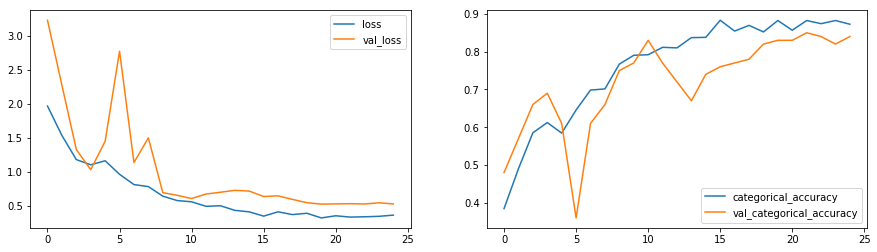

In [15]:
plot(history_model2)


In [16]:
conv_3d21=ModelConv3D1()
conv_3d21.initialize_params(image_height=160,image_width=160,frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d21_model=conv_3d21.define_model(dense_neurons=256,dropout=0.5)
print("Total Params:", conv_3d21_model.count_params())
conv_3d21_model.summary()

Total Params: 3638981
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_9 (Activation)    (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_10 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 10, 80, 80, 32)   

In [17]:
print("Total Params:", conv_3d21_model.count_params())
history_model2=conv_3d21.train_val_generate(conv_3d21_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
34/34 [==============================] - 146s 4s/step - loss: 1.8936 - categorical_accuracy: 0.3808 - val_loss: 3.1633 - val_categorical_accuracy: 0.4200

Epoch 00001: saving model to model_init_2020-06-3006_24_06.118853/model-00001-1.91504-0.37783-3.16334-0.42000.h5
Epoch 2/25
34/34 [==============================] - 135s 4s/step - loss: 1.5444 - categorical_accuracy: 0.4728 - val_loss: 2.1889 - val_categorical_accuracy: 0.4700

Epoch 00002: saving model to model_init_2020-06-3006_24_06.118853/model-00002-1.51268-0.47210-2.18888-0.47000.h5
Epoch 3/25
34/34 [==============================] - 138s 4s/step - loss: 1.2020 - categorical_accuracy: 0.5868 - val_loss: 1.9354 - val_categorical_accuracy: 0.4500

Epoch 00003: saving model to model_init_2020-06-3006_24_06.118853/model-00003-1.17396-0.58899-1.93541-0.45000.h5
Epoch 4/25
34/34 [==============================] - 137s 4s/step - loss: 1.1266 - categorical_accuracy: 0.6052 - val_loss: 0.8322 - val_categ

### Model 3 - Reduce filter size to (2,2,2) and image res to 120 x 120

In [18]:
class ModelConv3D3(AbsModel):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [19]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_params(image_height=120,image_width=120,frames_to_sample=16,batch_size=30,num_epochs=30)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
print("Total Params:", conv_3d3_model.count_params())
conv_3d3_model.summary()

Total Params: 1762613
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_13 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_14 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 8, 60, 60, 32)    

In [20]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_val_generate(conv_3d3_model,augment_data=True)

Total Params: 1762613
Epoch 1/30
23/23 [==============================] - 140s 6s/step - loss: 2.2289 - categorical_accuracy: 0.3068 - val_loss: 1.2667 - val_categorical_accuracy: 0.5100

Epoch 00001: saving model to model_init_2020-06-3007_21_45.289631/model-00001-2.24082-0.31222-1.26667-0.51000.h5
Epoch 2/30
23/23 [==============================] - 87s 4s/step - loss: 1.5325 - categorical_accuracy: 0.4755 - val_loss: 1.2868 - val_categorical_accuracy: 0.5600

Epoch 00002: saving model to model_init_2020-06-3007_21_45.289631/model-00002-1.57097-0.46154-1.28678-0.56000.h5
Epoch 3/30
23/23 [==============================] - 90s 4s/step - loss: 1.4389 - categorical_accuracy: 0.5257 - val_loss: 1.1357 - val_categorical_accuracy: 0.6600

Epoch 00003: saving model to model_init_2020-06-3007_21_45.289631/model-00003-1.37855-0.53318-1.13574-0.66000.h5
Epoch 4/30
23/23 [==============================] - 90s 4s/step - loss: 1.2182 - categorical_accuracy: 0.5704 - val_loss: 1.1283 - val_categori

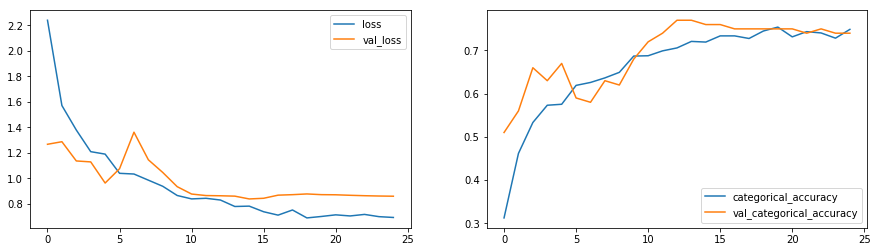

In [21]:
plot(history_model3)


### Model 4 Adding dropout at convolution layers

In [22]:
class ModelConv3D4(AbsModel):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [23]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_params(image_height=120,image_width=120,frames_to_sample=16,batch_size=20,num_epochs=22)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
print("Total Params:", conv_3d4_model.count_params())
conv_3d4_model.summary()

Total Params: 2556533
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_17 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_17 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_18 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 8, 60, 60, 16)    

In [24]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_val_generate(conv_3d4_model,augment_data=True)

Total Params: 2556533
Epoch 1/22
34/34 [==============================] - 116s 3s/step - loss: 1.7576 - categorical_accuracy: 0.3819 - val_loss: 4.2337 - val_categorical_accuracy: 0.3100

Epoch 00001: saving model to model_init_2020-06-3008_00_25.200558/model-00001-1.74015-0.38311-4.23370-0.31000.h5
Epoch 2/22
34/34 [==============================] - 95s 3s/step - loss: 1.3244 - categorical_accuracy: 0.5372 - val_loss: 1.9678 - val_categorical_accuracy: 0.5600

Epoch 00002: saving model to model_init_2020-06-3008_00_25.200558/model-00002-1.27561-0.54223-1.96779-0.56000.h5
Epoch 3/22
34/34 [==============================] - 98s 3s/step - loss: 1.0604 - categorical_accuracy: 0.5912 - val_loss: 2.2276 - val_categorical_accuracy: 0.5100

Epoch 00003: saving model to model_init_2020-06-3008_00_25.200558/model-00003-1.03885-0.59351-2.22764-0.51000.h5
Epoch 4/22
34/34 [==============================] - 102s 3s/step - loss: 0.9353 - categorical_accuracy: 0.6372 - val_loss: 2.1489 - val_categor

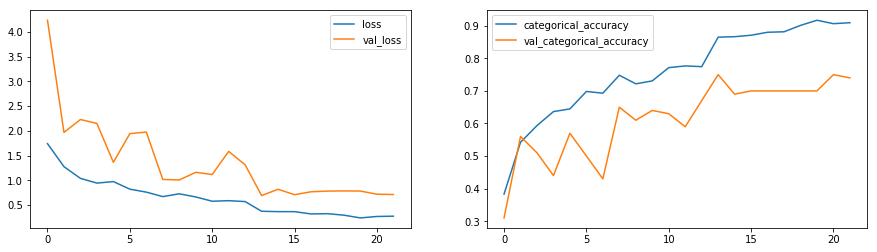

In [25]:
plot(history_model4)


Adding dropouts has further reduced validation accuracy as its not to learn generalizable features
All models experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance

### Model 5 - reducing the number of parameters

In [10]:
class ModelConv3D5(AbsModel):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [12]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_params(image_height=100,image_width=100,frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d5_model=conv_3d5.define_model(dense_neurons=128,dropout=0.25)
print("Total Params:", conv_3d5_model.count_params())
conv_3d5_model.summary()

Total Params: 696645
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_5 (Activation)    (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_6 (Activation)    (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 8, 50, 50, 32)     

In [13]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_val_generate(conv_3d5_model,augment_data=True)


Total Params: 696645
Epoch 1/30
34/34 [==============================] - 177s 5s/step - loss: 1.7973 - categorical_accuracy: 0.3587 - val_loss: 1.1369 - val_categorical_accuracy: 0.5700

Epoch 00001: saving model to model_init_2020-06-3009_22_10.607328/model-00001-1.80026-0.36350-1.13690-0.57000.h5
Epoch 2/30
34/34 [==============================] - 80s 2s/step - loss: 1.2789 - categorical_accuracy: 0.5276 - val_loss: 1.0363 - val_categorical_accuracy: 0.6100

Epoch 00002: saving model to model_init_2020-06-3009_22_10.607328/model-00002-1.23968-0.53243-1.03628-0.61000.h5
Epoch 3/30
34/34 [==============================] - 81s 2s/step - loss: 1.0747 - categorical_accuracy: 0.5872 - val_loss: 1.0522 - val_categorical_accuracy: 0.6100

Epoch 00003: saving model to model_init_2020-06-3009_22_10.607328/model-00003-1.07794-0.59351-1.05216-0.61000.h5
Epoch 4/30
34/34 [==============================] - 82s 2s/step - loss: 0.9228 - categorical_accuracy: 0.6501 - val_loss: 0.9210 - val_categoric

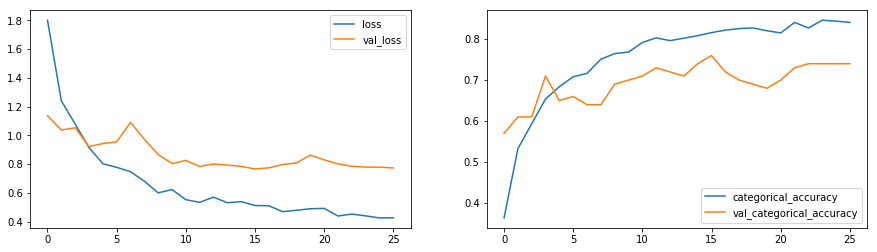

In [14]:
plot(history_model5)


For the above low memory foot print model the best validation accuracy of 77%¶


In [15]:
class ModelConv3D6(AbsModel):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [16]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_params(image_height=120,image_width=120,frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d6_model=conv_3d6.define_model(dense_neurons=64,dropout=0.25)
print("Total Params:", conv_3d6_model.count_params())
conv_3d6_model.summary()

Total Params: 230949
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 16, 120, 120, 8)   656       
_________________________________________________________________
activation_9 (Activation)    (None, 16, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 16, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 8, 60, 60, 8)      0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 8, 60, 60, 16)     3472      
_________________________________________________________________
activation_10 (Activation)   (None, 8, 60, 60, 16)     0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 8, 60, 60, 16)     

In [17]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_val_generate(conv_3d6_model,augment_data=True)

Total Params: 230949
Epoch 1/30
34/34 [==============================] - 94s 3s/step - loss: 1.9764 - categorical_accuracy: 0.2932 - val_loss: 1.3982 - val_categorical_accuracy: 0.4500

Epoch 00001: saving model to model_init_2020-06-3010_00_20.214011/model-00001-1.97186-0.29638-1.39824-0.45000.h5
Epoch 2/30
34/34 [==============================] - 86s 3s/step - loss: 1.4818 - categorical_accuracy: 0.4161 - val_loss: 1.3700 - val_categorical_accuracy: 0.4600

Epoch 00002: saving model to model_init_2020-06-3010_00_20.214011/model-00002-1.48040-0.42232-1.36996-0.46000.h5
Epoch 3/30
34/34 [==============================] - 89s 3s/step - loss: 1.2936 - categorical_accuracy: 0.4879 - val_loss: 1.1480 - val_categorical_accuracy: 0.4700

Epoch 00003: saving model to model_init_2020-06-3010_00_20.214011/model-00003-1.30767-0.48341-1.14804-0.47000.h5
Epoch 4/30
34/34 [==============================] - 89s 3s/step - loss: 1.2251 - categorical_accuracy: 0.5096 - val_loss: 1.1286 - val_categorica

34/34 [==============================] - 88s 3s/step - loss: 0.5466 - categorical_accuracy: 0.7965 - val_loss: 0.9067 - val_categorical_accuracy: 0.7300

Epoch 00030: saving model to model_init_2020-06-3010_00_20.214011/model-00030-0.51927-0.80392-0.90669-0.73000.h5


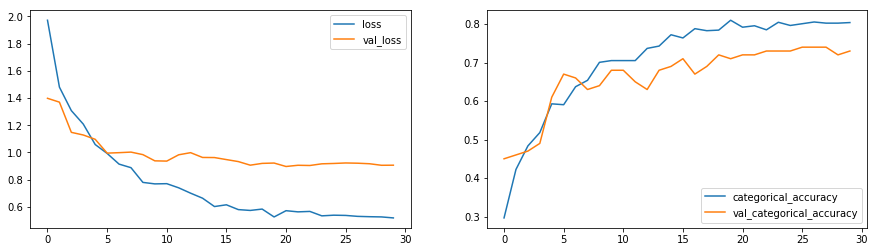

In [18]:
plot(history_model6)


In [ ]:
class ModelConv3D7(AbsModel):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(64, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(256, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(512, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        #model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        #model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [ ]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_params(image_height=120,image_width=120,frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
print("Total Params:", conv_3d7_model.count_params())
conv_3d7_model.summary()

In [ ]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_val_generate(conv_3d7_model,augment_data=True)

In [ ]:
plot(history_model7)

### Model CNN-RNN

In [19]:
class RNNCNN1(AbsModel):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [20]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_params(image_height=120,image_width=120,frames_to_sample=18,batch_size=20,num_epochs=30)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
print("Total Params:", rnn_cnn1_model.count_params())
rnn_cnn1_model.summary()

Total Params: 1657445
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 18, 30, 30, 64)   

In [21]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model7=rnn_cnn1.train_val_generate(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/30
34/34 [==============================] - 167s 5s/step - loss: 1.4526 - categorical_accuracy: 0.3602 - val_loss: 1.5866 - val_categorical_accuracy: 0.3900

Epoch 00001: saving model to model_init_2020-06-3010_44_49.550804/model-00001-1.43245-0.36501-1.58663-0.39000.h5
Epoch 2/30
34/34 [==============================] - 95s 3s/step - loss: 1.2041 - categorical_accuracy: 0.4923 - val_loss: 1.4782 - val_categorical_accuracy: 0.4000

Epoch 00002: saving model to model_init_2020-06-3010_44_49.550804/model-00002-1.18543-0.50452-1.47819-0.40000.h5
Epoch 3/30
34/34 [==============================] - 99s 3s/step - loss: 1.0017 - categorical_accuracy: 0.5968 - val_loss: 1.0440 - val_categorical_accuracy: 0.5400

Epoch 00003: saving model to model_init_2020-06-3010_44_49.550804/model-00003-0.98105-0.61161-1.04401-0.54000.h5
Epoch 4/30
34/34 [==============================] - 99s 3s/step - loss: 0.8854 - categorical_accuracy: 0.6490 - val_loss: 0.9427 - val_categori

34/34 [==============================] - 96s 3s/step - loss: 0.0496 - categorical_accuracy: 0.9860 - val_loss: 0.4100 - val_categorical_accuracy: 0.8500

Epoch 00030: saving model to model_init_2020-06-3010_44_49.550804/model-00030-0.04981-0.98567-0.41002-0.85000.h5


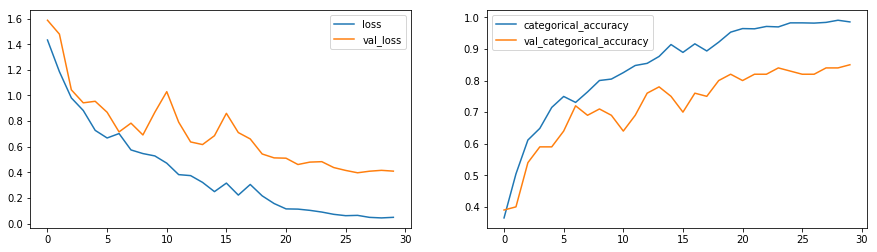

In [22]:
plot(history_model7)


### Model  - CNN LSTM with GRU 


In [33]:
class RNNCNN2(AbsModel):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
         
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        #model.add(GRU())
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [34]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_params(image_height=120,image_width=120,frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
print("Total Params:", rnn_cnn2_model.count_params())
rnn_cnn2_model.summary()

Total Params: 2573541
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_30 (TimeDis (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_31 (TimeDis (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_32 (TimeDis (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_33 (TimeDis (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_34 (TimeDis (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_35 (TimeDis (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_36 (TimeDis (None, 18, 30, 30, 64)   

In [35]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model17=rnn_cnn2.train_val_generate(rnn_cnn2_model,augment_data=True)

Total Params: 2573541
Epoch 1/20
34/34 [==============================] - 100s 3s/step - loss: 1.4828 - categorical_accuracy: 0.3720 - val_loss: 1.2339 - val_categorical_accuracy: 0.5400

Epoch 00001: val_loss improved from inf to 1.23387, saving model to model_init_2020-06-3011_35_58.870321/model-00001-1.47913-0.37707-1.23387-0.54000.h5
Epoch 2/20
34/34 [==============================] - 93s 3s/step - loss: 1.0926 - categorical_accuracy: 0.5651 - val_loss: 0.9986 - val_categorical_accuracy: 0.6400

Epoch 00002: val_loss improved from 1.23387 to 0.99863, saving model to model_init_2020-06-3011_35_58.870321/model-00002-1.10908-0.55430-0.99863-0.64000.h5
Epoch 3/20
34/34 [==============================] - 95s 3s/step - loss: 0.9385 - categorical_accuracy: 0.6328 - val_loss: 0.9376 - val_categorical_accuracy: 0.6200

Epoch 00003: val_loss improved from 0.99863 to 0.93761, saving model to model_init_2020-06-3011_35_58.870321/model-00003-0.95308-0.62368-0.93761-0.62000.h5
Epoch 4/20
34/34 [

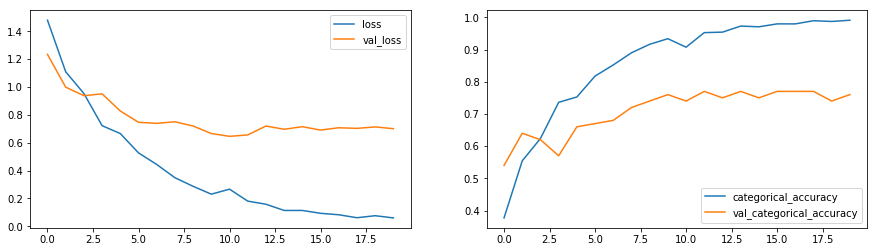

In [36]:
plot(history_model17)
    

In [37]:
class RNNCNN21(AbsModel):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        #model.add(GRU())
        #model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model



In [38]:
rnn_cnn21=RNNCNN21()
rnn_cnn21.initialize_params(image_height=120,image_width=120,frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn21_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
print("Total Params:", rnn_cnn21_model.count_params())
rnn_cnn21_model.summary()

Total Params: 2573541
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_43 (TimeDis (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_44 (TimeDis (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_45 (TimeDis (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_46 (TimeDis (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_47 (TimeDis (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_48 (TimeDis (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_49 (TimeDis (None, 18, 30, 30, 64)   

In [39]:
print("Total Params:", rnn_cnn21_model.count_params())
history_model171=rnn_cnn21.train_val_generate(rnn_cnn21_model,augment_data=True)

Total Params: 2573541
Epoch 1/20
34/34 [==============================] - 103s 3s/step - loss: 1.4934 - categorical_accuracy: 0.3738 - val_loss: 1.1972 - val_categorical_accuracy: 0.5300

Epoch 00001: val_loss improved from inf to 1.19717, saving model to model_init_2020-06-3012_08_12.470088/model-00001-1.49368-0.37481-1.19717-0.53000.h5
Epoch 2/20
34/34 [==============================] - 94s 3s/step - loss: 1.0939 - categorical_accuracy: 0.5504 - val_loss: 0.9583 - val_categorical_accuracy: 0.6100

Epoch 00002: val_loss improved from 1.19717 to 0.95834, saving model to model_init_2020-06-3012_08_12.470088/model-00002-1.08824-0.55581-0.95834-0.61000.h5
Epoch 3/20
34/34 [==============================] - 97s 3s/step - loss: 0.8668 - categorical_accuracy: 0.6600 - val_loss: 0.8521 - val_categorical_accuracy: 0.6200

Epoch 00003: val_loss improved from 0.95834 to 0.85208, saving model to model_init_2020-06-3012_08_12.470088/model-00003-0.86288-0.65988-0.85208-0.62000.h5
Epoch 4/20
34/34 [

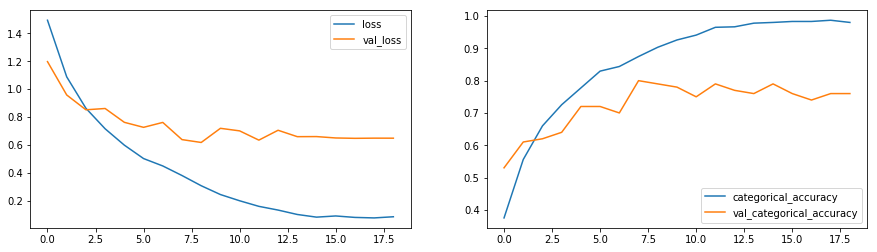

In [40]:
plot(history_model171)
    

### Model - Transfer Learning

In [41]:
from keras.applications import mobilenet


In [42]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(AbsModel):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17227776/17225924 [==============================] - 2s 0us/step


In [43]:
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_params(image_height=120,image_width=120,frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_56 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_57 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_58 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_59 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               590336    
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               16512     
__________

In [44]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model18=rnn_cnn_tl.train_val_generate(rnn_cnn_tl_model,augment_data=True)


Total Params: 3840453
Epoch 1/20
133/133 [==============================] - 92s 694ms/step - loss: 1.4425 - categorical_accuracy: 0.3739 - val_loss: 1.3635 - val_categorical_accuracy: 0.4500

Epoch 00001: val_loss improved from inf to 1.36353, saving model to model_init_2020-06-3012_39_31.268416/model-00001-1.44287-0.37406-1.36353-0.45000.h5
Epoch 2/20
133/133 [==============================] - 82s 614ms/step - loss: 1.1761 - categorical_accuracy: 0.5168 - val_loss: 1.2388 - val_categorical_accuracy: 0.5000

Epoch 00002: val_loss improved from 1.36353 to 1.23879, saving model to model_init_2020-06-3012_39_31.268416/model-00002-1.17576-0.51735-1.23879-0.50000.h5
Epoch 3/20
133/133 [==============================] - 85s 638ms/step - loss: 1.0278 - categorical_accuracy: 0.5865 - val_loss: 1.1386 - val_categorical_accuracy: 0.5400

Epoch 00003: val_loss improved from 1.23879 to 1.13861, saving model to model_init_2020-06-3012_39_31.268416/model-00003-1.02605-0.58673-1.13861-0.54000.h5
Epoc

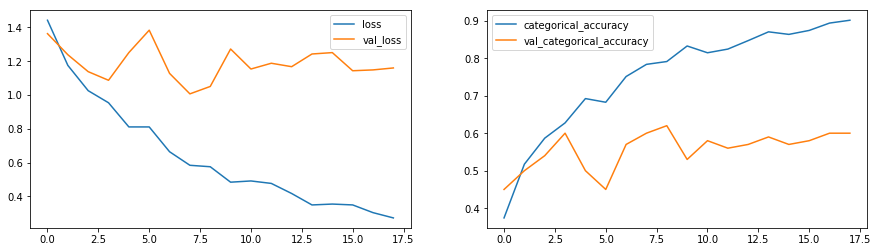

In [45]:
plot(history_model18)


### Model - Transfer Learning with GRU and training all weights¶


In [17]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TLGRU(AbsModel):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [18]:
rnn_cnn_tlgru=RNNCNN_TLGRU()
rnn_cnn_tlgru.initialize_params(image_height=100,image_width=100,frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tlgru_model=rnn_cnn_tlgru.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tlgru_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_6 (TimeDist (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 16, 1024)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
__________

In [19]:
print("Total Params:", rnn_cnn_tlgru_model.count_params())
history_modelgru=rnn_cnn_tlgru.train_val_generate(rnn_cnn_tlgru_model,augment_data=True)

Total Params: 3692869
Epoch 1/20
133/133 [==============================] - 97s 726ms/step - loss: 1.2741 - categorical_accuracy: 0.4814 - val_loss: 0.6033 - val_categorical_accuracy: 0.7500

Epoch 00001: val_loss improved from inf to 0.60331, saving model to model_init_2020-06-3013_23_25.104182/model-00001-1.27547-0.48039-0.60331-0.75000.h5
Epoch 2/20
133/133 [==============================] - 87s 655ms/step - loss: 0.7960 - categorical_accuracy: 0.6802 - val_loss: 0.6571 - val_categorical_accuracy: 0.7200

Epoch 00002: val_loss did not improve from 0.60331
Epoch 3/20
133/133 [==============================] - 90s 675ms/step - loss: 0.5361 - categorical_accuracy: 0.7787 - val_loss: 0.3960 - val_categorical_accuracy: 0.8000

Epoch 00003: val_loss improved from 0.60331 to 0.39603, saving model to model_init_2020-06-3013_23_25.104182/model-00003-0.53475-0.77903-0.39603-0.80000.h5
Epoch 4/20
133/133 [==============================] - 90s 675ms/step - loss: 0.5738 - categorical_accuracy: 0

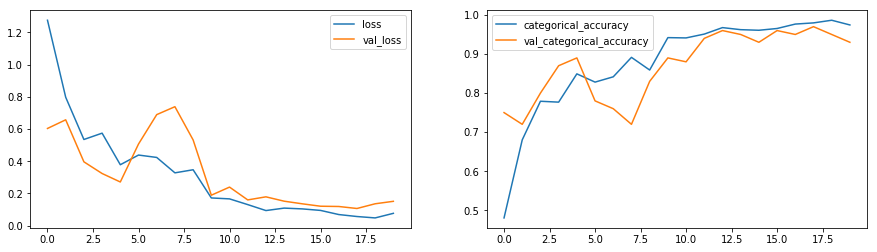

In [20]:
plot(history_modelgru)


### VGG16

In [21]:
mobilenet_transfer = VGG16(weights='imagenet', include_top=False)

class RNNCNN_TL22(AbsModel):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

58892288/58889256 [==============================] - 5s 0us/step


In [22]:
rnn_cnn_tl3=RNNCNN_TL22()
rnn_cnn_tl3.initialize_params(image_height=120,image_width=120,frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl3_model=rnn_cnn_tl3.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_9 (TimeDist (None, 16, 3, 3, 512)     14714688  
_________________________________________________________________
time_distributed_10 (TimeDis (None, 16, 3, 3, 512)     2048      
_________________________________________________________________
time_distributed_11 (TimeDis (None, 16, 1, 1, 512)     0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, 16, 512)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 128)               246144    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
__________

In [23]:
print("Total Params:", rnn_cnn_tl3_model.count_params())
history_model13=rnn_cnn_tl3.train_val_generate(rnn_cnn_tl3_model,augment_data=True)

Total Params: 14980037
Epoch 1/20
133/133 [==============================] - 191s 1s/step - loss: 1.6213 - categorical_accuracy: 0.2662 - val_loss: 1.7223 - val_categorical_accuracy: 0.2300

Epoch 00001: val_loss improved from inf to 1.72230, saving model to model_init_2020-06-3013_55_58.407014/model-00001-1.62303-0.26546-1.72230-0.23000.h5
Epoch 2/20
133/133 [==============================] - 168s 1s/step - loss: 1.5185 - categorical_accuracy: 0.2997 - val_loss: 1.7377 - val_categorical_accuracy: 0.1600

Epoch 00002: val_loss did not improve from 1.72230
Epoch 3/20
133/133 [==============================] - 168s 1s/step - loss: 1.4961 - categorical_accuracy: 0.3256 - val_loss: 1.3393 - val_categorical_accuracy: 0.4500

Epoch 00003: val_loss improved from 1.72230 to 1.33929, saving model to model_init_2020-06-3013_55_58.407014/model-00003-1.49658-0.32504-1.33929-0.45000.h5
Epoch 4/20
133/133 [==============================] - 168s 1s/step - loss: 1.4100 - categorical_accuracy: 0.3471 -

In [14]:
Vgg_transfer = VGG16(weights='imagenet', include_top=False)

class RNNCNN_TLVGG(AbsModel):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(Vgg_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(CuDNNLSTM(64,return_sequences=False))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam(lr=0.001)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [15]:
rnn_cnn_tlvgg=RNNCNN_TLVGG()
rnn_cnn_tlvgg.initialize_params(image_height=100,image_width=100,frames_to_sample=16,batch_size=20,num_epochs=20)
rnn_cnn_tlvgg_model=rnn_cnn_tlvgg.define_model(dense_neurons=128,dropout=0.5)
rnn_cnn_tlvgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 16, 3, 3, 512)     14714688  
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 3, 3, 512)     2048      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 1, 1, 512)     0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 16, 512)           0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 64)                147968    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
__________

In [16]:
print("Total Params:", rnn_cnn_tlvgg_model.count_params())
history_model14=rnn_cnn_tlvgg.train_val_generate(rnn_cnn_tlvgg_model,augment_data=True)

Total Params: 14873669
Epoch 1/20
34/34 [==============================] - 182s 5s/step - loss: 1.5994 - categorical_accuracy: 0.2723 - val_loss: 1.4741 - val_categorical_accuracy: 0.4100

Epoch 00001: val_loss improved from inf to 1.47414, saving model to model_init_2020-06-3015_55_37.669083/model-00001-1.60402-0.27074-1.47414-0.41000.h5
Epoch 2/20
34/34 [==============================] - 81s 2s/step - loss: 1.3586 - categorical_accuracy: 0.4242 - val_loss: 1.3180 - val_categorical_accuracy: 0.5000

Epoch 00002: val_loss improved from 1.47414 to 1.31803, saving model to model_init_2020-06-3015_55_37.669083/model-00002-1.36076-0.42232-1.31803-0.50000.h5
Epoch 3/20
34/34 [==============================] - 87s 3s/step - loss: 1.1252 - categorical_accuracy: 0.5703 - val_loss: 1.2753 - val_categorical_accuracy: 0.4500

Epoch 00003: val_loss improved from 1.31803 to 1.27533, saving model to model_init_2020-06-3015_55_37.669083/model-00003-1.13649-0.56787-1.27533-0.45000.h5
Epoch 4/20
34/34 